Flex all X-axes joints of the robox.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from os.path import dirname
sys.path.append(os.path.join(os.getcwd(), '..'))

In [21]:
import cv2
import pybullet as p
import numpy as np
import pylab

from opencv.opencv_tools import save
from pyb.pybullet_robot import PyBulletRobot
from opencv.opencv_pose import Pose
from phy.phy_robot import PhyRobot

In [61]:
vr = PyBulletRobot(render=True)

*** Initializing PyBulletRobot(ns=4, render=True) ...
*** Initializing PyBulletRobot() done


In [62]:
def phis_1x(phix):
    phis = np.array([[phix, 0], [phix, 0], [phix, 0], [phix, 0]])
    return phis

def vr_sweep(phixs):
    phiss, camps, tvecs, rvecs = [], [], [], []

    first_phi, last_phi = None, None
    vpose = Pose(vr.W, vr.H, '../pyb/cal.npz', vr.D)

    for phix in phixs:
        phis = phis_1x(phix)                  
        vr.step(phis)
        img, cam_p, _, _, _ = vr.getHeadcam()
        retval, rvec, tvec, _ = vpose.findChessboardRTVecs(img)
        if retval:
            camps.append(cam_p)
            tvecs.append(tvec)
            rvecs.append(rvec)
            phiss.append(phis)

            if first_phi is None:
                first_phi = last_phi = phix
                print("vr first_phi: %f" % first_phi)
            elif last_phi < phix:
                last_phi = phix

    print("vr last_phi: %f" % last_phi)

    phiss = np.array(phiss)
    camps = np.array(camps)
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)

    return phiss, camps, tvecs, rvecs


def rr_sweep(phixs):
    phiss, tvecs, rvecs = [], [], []

    PHIX_LOW, PHIX_HIGH = np.pi/12, np.pi/6
    DPHI = (PHIX_HIGH - PHIX_LOW) / 25

    first_phi, last_phi = None, None
    vpose = Pose(rr.W, rr.H, '../phy/cal.npz', rr.D)

    for phix in phixs:
        print("phix=%s" % phix)
        phis = phis_1x(phix)                  
        rr.step(phis)
        
        img, _, _, _, _ = rr.getHeadcam()
        retval, rvec, tvec, _ = vpose.findChessboardRTVecs(img)
        if retval:
            phiss.append(phis)
            rvecs.append(rvec)
            tvecs.append(tvec)

            if first_phi is None:
                first_phi = last_phi = phix
                print("rr first_phi: %f" % first_phi)
            elif last_phi < phix:
                last_phi = phix

    print("rr last_phi: %s" % last_phi)


    phiss = np.array(phiss)
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)

    return phiss, tvecs, rvecs

In [63]:
PHIX_LOW, PHIX_HIGH = np.pi/12, np.pi/6
DPHI = (PHIX_HIGH - PHIX_LOW) / 25
phixs = np.arange(PHIX_LOW, PHIX_HIGH+DPHI, DPHI)

## VR robot

In [64]:
phiss, camps, tvecs, rvecs = vr_sweep(phixs)

# distance from damera position to the center of the chessboard
camds = []
for cam_p in camps:
    cam_d = np.sqrt(np.sum(np.square(np.array(cam_p) - np.array([2, 0, 0.59])), axis=0))
    camds.append(cam_d)
camds = np.array(camds)

# length of the translation vector
tvecds = np.sqrt(np.sum(np.square(tvecs), axis=1)).ravel()

vr first_phi: 0.324631
vr last_phi: 0.439823


#### head moves down on Z world axis

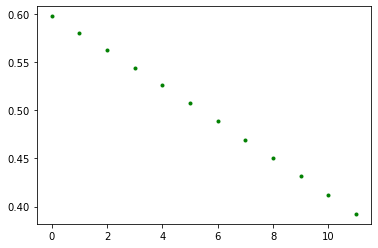

In [33]:
plt.plot(camps[:,2], 'g.')

#### target Y component of translation vector sweeps from 0.6 to -0.6

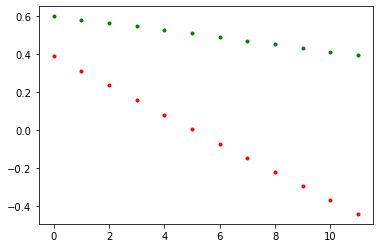

In [34]:
plt.plot(camps[:,2], 'g.', tvecs[:,1], 'r.')

#### headcam sways horizontally a tiny bit

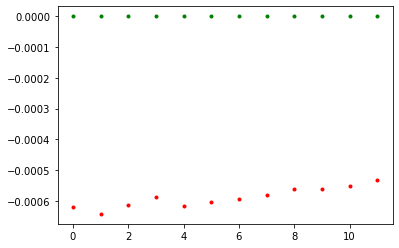

In [35]:
plt.plot(camps[:,1], 'g.', tvecs[:,0], 'r.')

#### headcam gets closer to the target

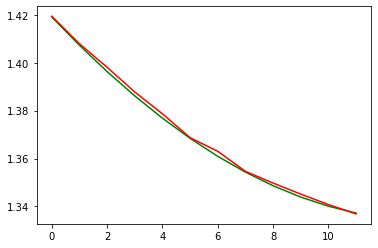

In [38]:
plt.plot(camds, 'g', tvecds, 'r')

In [39]:
tvecds

array([1.41940687, 1.40790607, 1.39807363, 1.38775289, 1.37865122,
       1.36869184, 1.36298814, 1.35461262, 1.34973841, 1.34512216,
       1.34077017, 1.33685953])

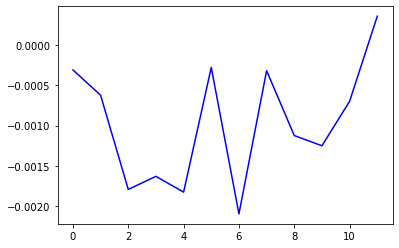

In [40]:
plt.plot(camds - tvecds, 'b')

####  Z component of translation vector reaches it peak and goes away

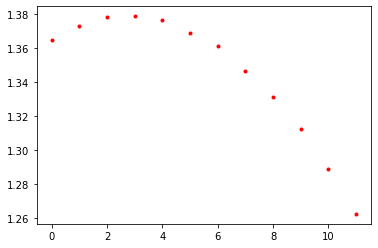

In [41]:
plt.plot(tvecs[:,2], 'r.')

#### Rotation vectors

In [68]:
def rodrigues_to_euler_angles(rvec):
        mat, jac = cv2.Rodrigues(rvec)

        sy = np.sqrt(mat[0, 0] * mat[0, 0] + mat[1, 0] * mat[1, 0])

        singular = sy < 1e-6

        if not singular:
            x = np.math.atan2(mat[2, 1], mat[2, 2])
            y = np.math.atan2(-mat[2, 0], sy)
            z = np.math.atan2(mat[1, 0], mat[0, 0])

        else:
            x = np.math.atan2(-mat[1, 2], mat[1, 1])
            y = np.math.atan2(-mat[2, 0], sy)
            z = 0

        return np.array([x, y, z])

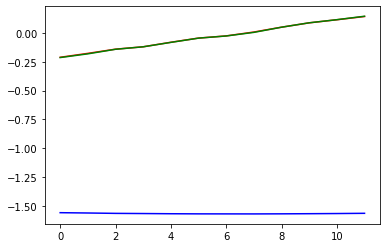

In [77]:
_ = plt.plot(rvecs[:,0], 'r', rvecs[:,1], 'g', rvecs[:,2], 'b', )

In [74]:
evecs=[]
for rvec in rvecs:
    evec = rodrigues_to_euler_angles(rvec)
    evecs.append(evec)
evecs=np.array(evecs)

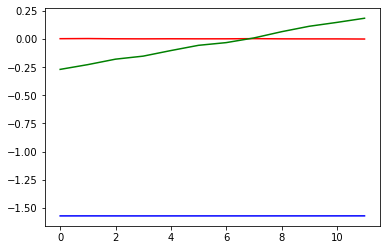

In [76]:
_ = plt.plot(evecs[:,0], 'r', evecs[:,1], 'g', evecs[:,2], 'b', )

In [42]:
vr.close()

*** PyBulletRobot() closed ***


## Real Robot

In [50]:
rr = PhyRobot()

#DRY _open_stream: port=/dummy1
#DRY _open_stream: port=/dummy2
Current resolution: 1280.0x720.0
New resolution: 1280.0x720.0


In [ ]:
r_phiss, r_tvecs, r_rvecs = rr_sweep(phixs)
r_tvecds = np.sqrt(np.sum(np.square(r_tvecs), axis=1)).ravel()

In [58]:
plt.plot(phiss[:,0,0], tvecds, 'g', r_phiss[:,0,0], r_tvecds, 'g', )

IndexError: too many indices for array